In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework2

Mounted at /gdrive
/gdrive/My Drive/Homework2


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

## Import the data

In [5]:
dataset = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
cat = np.load('categories.npy')
print(dataset.shape)
print(periods.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [6]:
# Building X and y sets: X is made of sequences of length window, and y is the subsequent sequence of length telescope.
X = []
y = []
categories = []    # not needed for this architecture
window = 45
telescope = 9
stride = 10
for i in range(dataset.shape[0]):
  j = periods[i,0]    # starting from this position allows to discard the padding
  while(j+window+telescope < periods[i,1]):    # check that both window and telescope fit in the timeseries
    X.append(dataset[i,j:j+window])
    y.append(dataset[i,j+window:j+window+telescope])
    j = j+stride

In [7]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((713619, 45), (713619, 9))

In [8]:
# creating train and test
test_size = int(0.9 * X.shape[0])    # keep 10% of the data for testing
X_train, X_test = np.split(X,[test_size])
y_train, y_test = np.split(y,[test_size])
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(642257, 45) (642257, 9) (71362, 45) (71362, 9)


In [ ]:
for i,element in enumerate(X_train):    # qua aggiungo rumore uniformemente distribuito al training set, l'ho solo scritta ma mai usata perché non so se funzioni
  element = scipy.signal.savgol_filter(element, 16, 4, deriv=0, delta=1.0, axis=0, mode='interp', cval=0.0)

In [9]:
X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(642257, 45, 1)

In [10]:
y_train = np.expand_dims(y_train,axis=2)
y_train.shape

(642257, 9, 1)

In [11]:
y_test = np.expand_dims(y_test,axis=2)
y_test.shape

(71362, 9, 1)

In [12]:
X_test = np.expand_dims(X_test,axis=2)
X_test.shape

(71362, 45, 1)

In [13]:
del X
del y
del dataset

## Build and train the model

In [14]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [15]:
input_shape, output_shape

((45, 1), (9, 1))

In [35]:
def build_model(input_shape, output_shape):

    # Define the input layers with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # first convolutional block
    x = tfkl.Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = tfkl.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(rate=1/8)(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)

    # second convolutional block
    x = tfkl.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = tfkl.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(rate=1/8)(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)

    x = tfkl.Conv1D(output_shape[1], 5, padding='same')(x)
    x = tfkl.Dropout(rate=1/8)(x)

    # output stage
    output_layer = tfkl.Conv1D(output_shape[1], 5, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size))(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4), metrics=['mae'])

    return model

Model: "CONV_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 45, 1)]           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 45, 32)            128       
                                                                 
 conv1d_21 (Conv1D)          (None, 45, 64)            6208      
                                                                 
 batch_normalization_3 (Bat  (None, 45, 64)            256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 45, 64)            0         
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 22, 64)            0         
 g1D)                                                   

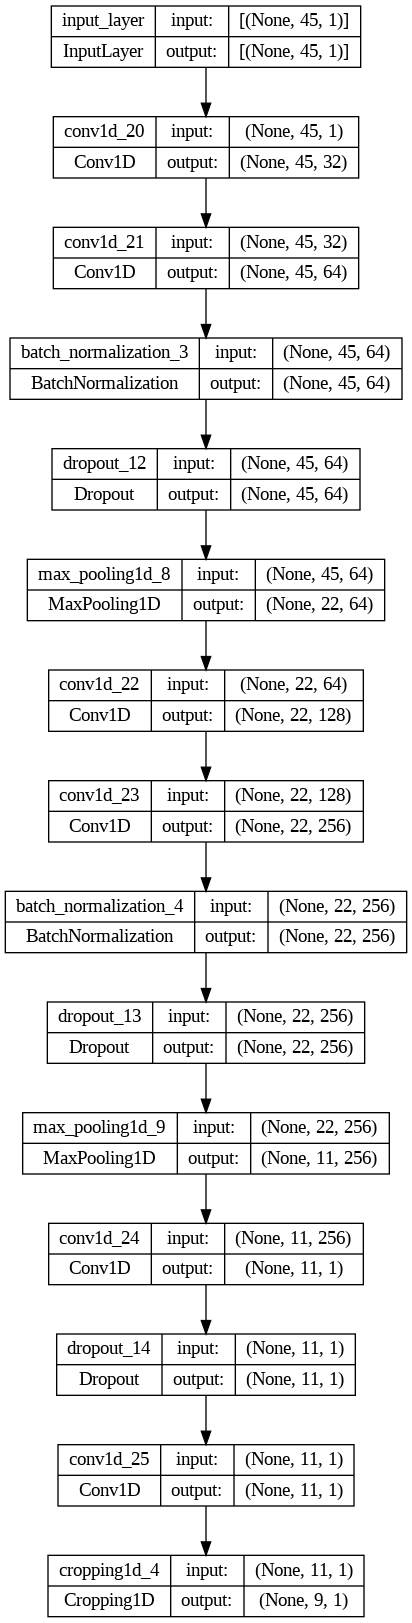

In [36]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [37]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
9032/9032 [==============================] - 76s 8ms/step - loss: 0.0442 - mae: 0.1447 - val_loss: 0.0141 - val_mae: 0.0860 - lr: 3.0000e-04
Epoch 2/200
9032/9032 [==============================] - 70s 8ms/step - loss: 0.0163 - mae: 0.0924 - val_loss: 0.0128 - val_mae: 0.0798 - lr: 3.0000e-04
Epoch 3/200
9032/9032 [==============================] - 88s 10ms/step - loss: 0.0157 - mae: 0.0903 - val_loss: 0.0134 - val_mae: 0.0818 - lr: 3.0000e-04
Epoch 4/200
9032/9032 [==============================] - 71s 8ms/step - loss: 0.0154 - mae: 0.0893 - val_loss: 0.0129 - val_mae: 0.0801 - lr: 3.0000e-04
Epoch 5/200
9032/9032 [==============================] - 74s 8ms/step - loss: 0.0153 - mae: 0.0888 - val_loss: 0.0140 - val_mae: 0.0846 - lr: 3.0000e-04
Epoch 6/200
9032/9032 [==============================] - 72s 8ms/step - loss: 0.0152 - mae: 0.0884 - val_loss: 0.0124 - val_mae: 0.0765 - lr: 3.0000e-04
Epoch 7/200
9032/9032 [==============================] - 72s 8ms/step - loss: 0.0

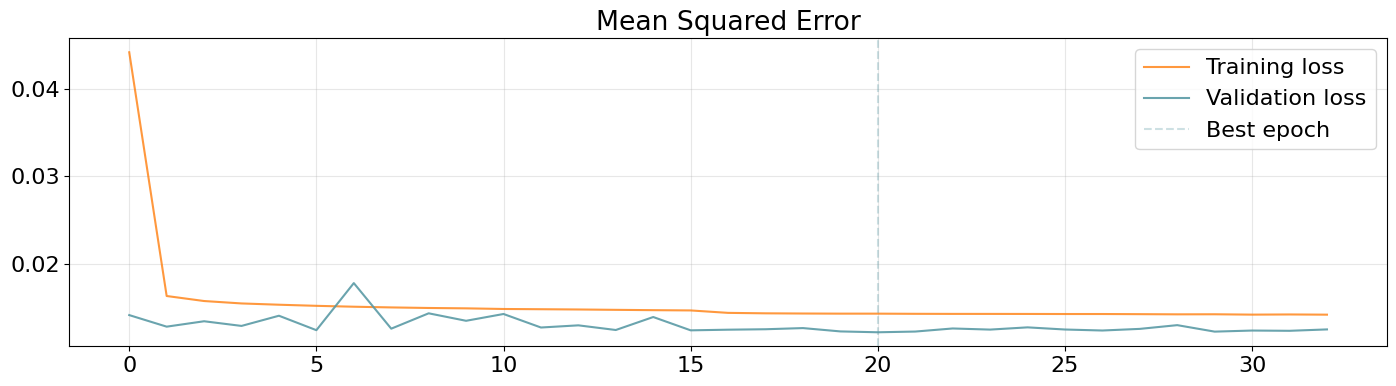

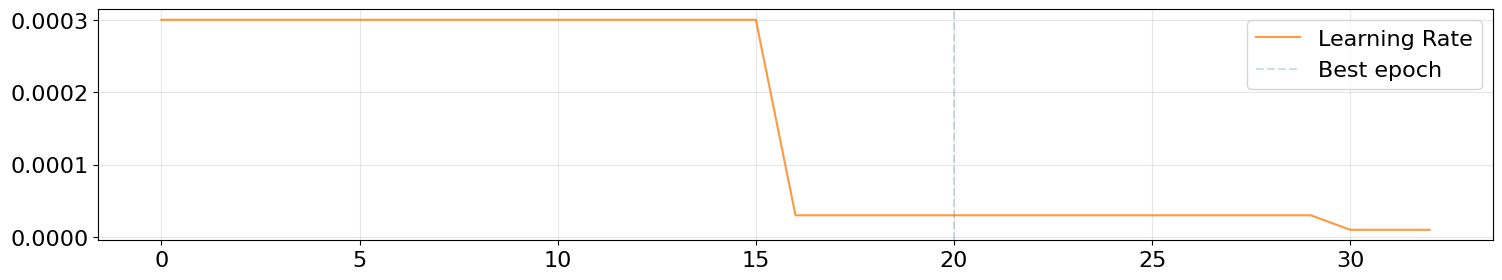

In [38]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [39]:
model.save('FinalModel')
del model
model = tfk.models.load_model('FinalModel')

## Inference

In [40]:
# Predict the test set using the model
predictions = model.predict(X_test)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

2231/2231 [==============================] - 5s 2ms/step
Predictions shape: (71362, 9, 1)
Mean Squared Error: 0.01758648082613945
Mean Absolute Error: 0.09274925291538239


In [41]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    plt.plot(np.arange(window), X[idx,:,:])
    plt.plot(np.arange(window,window+telescope), y[idx,:,:], color='orange')
    plt.plot(np.arange(window,window+telescope), pred[idx,:,:], color='green')
    plt.ylim(0,1)
    plt.show()

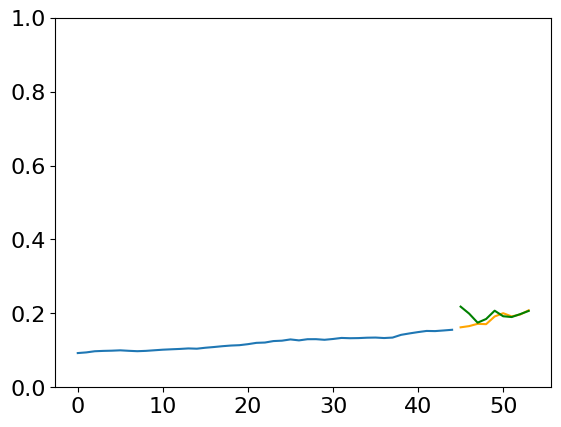

In [45]:
inspect_multivariate_prediction(X_test, y_test, predictions, telescope)
# in orange the ground truth, in green the predictions